In [1]:
import numpy as np
import cv2
from scipy.optimize import lsq_linear
# from jetbot import Robot, Camera, bgr8_to_jpeg
from IPython.display import display, Image, clear_output
import CP_constants as const
from collections import deque  
import ipywidgets as widgets

def bgr8_to_jpeg(image, quality=90):
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Invalid image for JPEG encoding")

    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, jpeg = cv2.imencode('.jpg', image, encode_params)
    if not success:
        raise ValueError("JPEG encoding failed")
    return jpeg.tobytes()


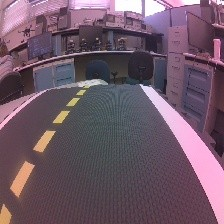

In [2]:
image = cv2.imread('Test_Lane_Images/image_1.jpg')
display(Image(data=bgr8_to_jpeg(image)))

In [3]:
"""

 Title: Lane Detection Algorithm
 Author: Anton Elmiger
 Created: 2020-05-26

 Information: Class that extracts a lane from an edge image
              and calculates the corresponding hyperbola-pair parameters

              Lane Model is described in this paper https://ieeexplore.ieee.org/abstract/document/1689679
              and in the wiki of github

"""

      
class Lane_Detection:
    def __init__(self):
        self.v = np.arange(0, const.IMAGE_HEIGHT, 1)  # vertical points
        self.u = np.arange(0, const.IMAGE_WIDTH, 1)  # horizontal points

        self.threshold = const.BOUNDARY_THRESH
        self.lane_width = const.LANE_WIDTH

        self.h = const.HORIZON # h-horizon height
        self.k = 0  # k-curvature of lane
        self.bl = 0 # b-skew of left lane
        self.br = 0 # b-skew of right lane
        self.bc = 0 # b-skew of lane center
        self.c = 0 # c-horizontal offset of lane

        self.bcdq = deque(maxlen=const.FILTER_STRENGTH)   
        self.bldq = deque(maxlen=const.FILTER_STRENGTH)   
        self.brdq = deque(maxlen=const.FILTER_STRENGTH)   

        self.left_lane_points = np.array([])
        self.right_lane_points = np.array([])
        
        self.lane = np.array([])

        # Bounds for the solving of hyperbola-pair parameters
        # [k,bl,br,c]
        # The constraint on c dramatically increases robustness
        self.low_b = np.array([-500000, -8, -8, const.IMAGE_WIDTH/2 -20])
        self.up_b = np.array([500000, 8, 8, const.IMAGE_WIDTH/2 +20])

    # Calculate lane hyperbola for given parameters
    def hyperbola_pair(self, b, v_values=None):
        if v_values is None:
            v_values = self.v
        return self.k / (v_values - self.h + 1e-6) + b * (v_values - self.h) + self.c


    # Function finds lane points in an edge image and classifies them to left and right lane
    # This function is used if no lane estimate exists, or the estimation is odd
    def get_initial_lane_points(self, edge_image):
        image_height = edge_image.shape[0]
        image_width = edge_image.shape[1]

        # initialize lane arrays
        left_lane_points = np.empty((image_height, 1))
        left_lane_points[:] = np.nan
        right_lane_points = np.empty((image_height, 1))
        right_lane_points[:] = np.nan

        lane_numbers = np.arange(image_width)
        edge_image = edge_image / 255

        for row in range(image_height-1, -1, -1):
            curr_row = edge_image[row, :]
            mid_x = image_width // 2

            edge_indices = np.where(curr_row > 0)[0]
            if edge_indices.size == 0:
                continue

            left_candidates = edge_indices[edge_indices < mid_x]
            right_candidates = edge_indices[edge_indices >= mid_x]

            if left_candidates.size > 0:
                left_lane_points[row] = np.max(left_candidates)
            if right_candidates.size > 0:
                right_lane_points[row] = np.min(right_candidates)

            if row == 300:
                break

        self.left_lane_points = left_lane_points
        self.right_lane_points = right_lane_points

    # # Function finds lane points in an edge image and classifies them to left and right lane
    # def lane_points(self, edge_image):
    #     image_height = edge_image.shape[0]

    #     # initialize lane arrays
    #     left_lane_points = np.empty((image_height, 1))
    #     left_lane_points[:] = np.nan
    #     right_lane_points = np.empty((image_height, 1))
    #     right_lane_points[:] = np.nan
        
    #     # get the "bounding" lanes to filter outliers
    #     # only points between the bounds are considered inliers
    #     left_max_bound, left_min_bound, right_max_bound, right_min_bound = self.generate_bounding_lanes()

    #     # only considere points that are below the horizon (plus some extra space for robustness) if the horizon is in the image
    #     horizon_index = int(max(self.h+20,0))

    #     # get the 2D image position of edge pixels that are below the horizon index
    #     nonzero = cv2.findNonZero(edge_image[horizon_index:]).reshape((-1,2)).T
    #     # offset the Y-Coordinate by the horizon index
    #     nonzero[1] += horizon_index

    #     # classify all points in left bounding area as left lane points
    #     left_p = nonzero.T[(nonzero[0] < left_max_bound[nonzero[1]]) & (nonzero[0] > left_min_bound[nonzero[1]])]

    #     # classify all points in right bounding area as left right points
    #     # the flipping of the array is imortant for the next step
    #     right_p = np.flipud(nonzero.T[(nonzero[0] < right_max_bound[nonzero[1]]) & (nonzero[0] > right_min_bound[nonzero[1]])])

    #     # for each vertical row in the image that contains a left lane point ->
    #     # place the point that is closest the the centerline into the left lane points array
    #     np.put(left_lane_points,left_p[:,1],left_p[:,0])
        
    #     # for each vertical row in the image that contains a right lane point ->
    #     # place the point that is closest the the centerline into the right lane points array
    #     np.put(right_lane_points,right_p[:,1],right_p[:,0])

    #     self.left_lane_points = left_lane_points
    #     self.right_lane_points = right_lane_points
    def lane_points(self, edge_image):
        image_height, image_width = edge_image.shape

        left_lane_points = np.full((image_height,), np.nan)
        right_lane_points = np.full((image_height,), np.nan)

        # Get bounding hyperbolas
        left_max_bound, left_min_bound, right_max_bound, right_min_bound = self.generate_bounding_lanes()

        # Horizon cutoff
        horizon_index = int(max(self.h + 20, 0))
        edge_points = cv2.findNonZero(edge_image[horizon_index:])

        if edge_points is None:
            self.left_lane_points = left_lane_points.reshape(-1, 1)
            self.right_lane_points = right_lane_points.reshape(-1, 1)
            return

        edge_points = edge_points.reshape((-1, 2))
        edge_points[:, 1] += horizon_index  # adjust Y

        image_mid_x = image_width // 2

        for y in range(horizon_index, image_height):
            y_mask = edge_points[:, 1] == y
            row_points = edge_points[y_mask]

            if row_points.size == 0:
                continue

            u_values = row_points[:, 0]

            # Lane bounds at row y
            lmin = left_min_bound[y]
            lmax = left_max_bound[y]
            rmin = right_min_bound[y]
            rmax = right_max_bound[y]

            # Split into left/right by expected location relative to image center
            left_candidates = u_values[(u_values > lmin) & (u_values < lmax) & (u_values < image_mid_x)]
            right_candidates = u_values[(u_values > rmin) & (u_values < rmax) & (u_values >= image_mid_x)]

            if len(left_candidates) > 0:
                left_lane_points[y] = left_candidates[np.argmin(np.abs(left_candidates - image_mid_x))]

            if len(right_candidates) > 0:
                right_lane_points[y] = right_candidates[np.argmin(np.abs(right_candidates - image_mid_x))]

        self.left_lane_points = left_lane_points.reshape(-1, 1)
        self.right_lane_points = right_lane_points.reshape(-1, 1)




    # Function returns lane lines, that are left and right of the estimated lane lines
    # These bounding lines are then used to define an inlier area
    def generate_bounding_lanes(self):
        # horizontal points left lane
        left_max = self.hyperbola_pair(self.bl+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        left_min = self.hyperbola_pair(self.bl-(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_max = self.hyperbola_pair(self.br+(self.bc-self.bl)/self.threshold)
        # horizontal points left lane
        right_min = self.hyperbola_pair(self.br-(self.bc-self.bl)/self.threshold)
        return left_max, left_min, right_max, right_min


    # Function solves for hyperbola-pair lane parameters
    # More info is in the paper listed at the top of this file
    def solve_lane(self):
        # generate matrices for lsq solver
        A, b = self.preprocess_for_solving()
        # returning the solved parameters (k,bl,br,c)
        self.solving_lane_params(A, b)

    # def preprocess_for_solving(self):
    #     l = self.left_lane_points
    #     r = self.right_lane_points
    #     print(self.v)
    #     # following lines create A matrix  and b vector for least square porblem
    #     l_ind = ~np.isnan(l)
    #     r_ind = ~np.isnan(r)
    #     l_num = l[l_ind]
    #     r_num = r[r_ind]
    #     vl = self.v[l_ind.flatten()]
    #     vr = self.v[r_ind.flatten()]
    #     print(vl)
    #     # --------------------------------------------------------------NEW
    #     epsilon = 2  # or higher if image is very small
    #     l_valid = np.abs(vl - self.h) > epsilon
    #     r_valid = np.abs(vr - self.h) > epsilon

    #     vl = vl[l_valid]
    #     vr = vr[r_valid]
    #     l_num = l_num[l_valid]
    #     r_num = r_num[r_valid]


    #     l_num = l_num.reshape((len(l_num), 1))
    #     r_num = r_num.reshape((len(r_num), 1))
    #     vl = vl.reshape(l_num.shape)
    #     vr = vr.reshape(r_num.shape)

    #     lh = (vl-self.h)
    #     lA = 1/lh
    #     rh = (vr-self.h)
    #     rA = 1/rh
    #     ones = np.ones(l_num.shape)
    #     zeros = np.zeros(l_num.shape)
    #     LA = np.hstack((np.hstack((lA, lh)), np.hstack((zeros, ones))))
    #     ones = np.ones(r_num.shape)
    #     zeros = np.zeros(r_num.shape)
    #     RA = np.hstack((np.hstack((rA, zeros)), np.hstack((rh, ones))))
    #     A = np.vstack((LA, RA))
    #     b = (np.concatenate((l_num, r_num))).flatten()
    #     return A, b
    def preprocess_for_solving(self):
        l = self.left_lane_points
        r = self.right_lane_points
        print(l)

        v_l = self.v[:l.shape[0]]
        v_r = self.v[:r.shape[0]]

        l_ind = (~np.isnan(l)).flatten()
        r_ind = (~np.isnan(r)).flatten()

        l_num = l[l_ind]
        r_num = r[r_ind]
        vl = v_l[l_ind]
        vr = v_r[r_ind]

        epsilon = 2
        l_valid = np.abs(vl - self.h) > epsilon
        r_valid = np.abs(vr - self.h) > epsilon

        vl = vl[l_valid]
        vr = vr[r_valid]
        l_num = l_num[l_valid]
        r_num = r_num[r_valid]

        if len(vl) == 0 or len(vr) == 0:
            raise ValueError("No valid points to fit lane model.")

        l_num = l_num.reshape((-1, 1))
        r_num = r_num.reshape((-1, 1))
        vl = vl.reshape(l_num.shape)
        vr = vr.reshape(r_num.shape)

        lh = (vl - self.h)
        rh = (vr - self.h)
        lA = 1 / lh
        rA = 1 / rh

        LA = np.hstack([lA, lh, np.zeros_like(lh), np.ones_like(lh)])
        RA = np.hstack([rA, np.zeros_like(rh), rh, np.ones_like(rh)])

        A = np.vstack([LA, RA])
        b = np.concatenate((l_num, r_num)).flatten()

        return A.astype(np.float64), b.astype(np.float64)


    def solving_lane_params(self, A, b):
        x = lsq_linear(A, b, bounds=(self.low_b, self.up_b), method='bvls', max_iter = 3).x
        # set new lane model param from least square solution
        self.k = x[0]
        self.bl=x[1]
        self.br=x[2]
        self.c = x[3]
        self.bc = (x[1]+x[2])/2
        # calc lane points
        self.v_fit = self.v[self.v > self.h + 2]
        self.lane = self.hyperbola_pair(self.bc, self.v_fit)

        # v_valid = ~np.isnan(self.left_lane_points.reshape(-1)) | ~np.isnan(self.right_lane_points.reshape(-1))
        # v_fit = self.v[v_valid]
        # # self.lane = self.k / (v_fit - self.h) + self.bc * (v_fit - self.h) + self.c
        # self.v_fit = v_fit  # store it for drawing
        # self.lane = self.hyperbola_pair(self.bc)


    # function corrects false lane lines or missing lane lines
    def lane_sanity_checks(self,edge_image):
        #lane not found
        if self.k == 0:
            self.get_initial_lane_points(edge_image)
            self.solve_lane()

        #Only one lane found
        self.interpolate_missing_lane()            

        #Lane width not correct size
        self.adjust_lane_width()            

        #Vehicle not on lane -> recenter lane line
        self.recenter_lane()
    
        #smooth lane
        self.filter_lane()
         
        self.lane = self.hyperbola_pair(self.bc)

    def interpolate_missing_lane(self):
        #Only one lane found
        if ~np.isfinite(self.left_lane_points).any():
            self.bl = self.br-self.lane_width-0.3
            self.bc = (self.bl+self.br)/2            
        if ~np.isfinite(self.right_lane_points).any():
            self.br = self.bl+self.lane_width+0.3
            self.bc = (self.bl+self.br)/2            

    def adjust_lane_width(self):
        #Lane width not correct size
        if abs(self.bl-self.br)<(self.lane_width*0.8) or abs(self.bl-self.br)>(self.lane_width)*1.2:
            length_l = np.count_nonzero(~np.isnan(self.left_lane_points))
            length_r = np.count_nonzero(~np.isnan(self.right_lane_points))
            if length_l > length_r:
                self.br = self.bl+self.lane_width
            else:
                self.bl = self.br-self.lane_width
            self.bc = (self.bl+self.br)/2            

    def recenter_lane(self):
        #Vehicle not on lane -> recenter lane line
        if self.bc > (self.lane_width/1.1):
            self.bl=self.bl-self.lane_width
            self.br=self.br-self.lane_width

        if self.bc < (-self.lane_width/1.1):
            self.bl=self.bl+self.lane_width
            self.br=self.br+self.lane_width

    def filter_lane(self):
        self.bc = (self.bl+self.br)/2 
        self.bcdq.append(self.bc)
        self.bc = sum(bc for bc in self.bcdq)/len(self.bcdq)
        self.bldq.append(self.bl)
        self.bl = sum(bc for bc in self.bldq)/len(self.bldq)
        self.brdq.append(self.br)
        self.br = sum(bc for bc in self.brdq)/len(self.brdq)

In [4]:
"""

 Title: Transform Points
 Author: Anton Elmiger
 Created: 2020-05-26

 Information: Class used to transform Points between camera space and world
              space
"""
from scipy.spatial.transform import Rotation as R


class Transform_Points:
    def __init__(self,_cam_angle=45):
        # cam angle from horizontal down in [degrees]]
        cam_angle = _cam_angle

        self.rot_mat_inv = R.from_euler(
            'xyz', [-90-cam_angle, 0, -90], degrees=True).as_matrix()
        self.rot_mat = np.linalg.inv(self.rot_mat_inv)

        # fov = 160 #fov in degrees/2
        width = const.IMAGE_WIDTH
        height = const.IMAGE_HEIGHT
        aspect_ratio = width / height
        fx = 417/2  # width / (np.tan(np.radians(fov) / 2) * 2)
        fy = fx
        self.cameraMatrix = np.array(
            [[fx, 0, width / 2], [0, fy, height / 2], [0, 0, 1]])
        self.cameraMatrixInv = np.linalg.inv(self.cameraMatrix)
        self.tt = -np.array([[0.182], [0.], [0.195]])
        self.rotationMatrix = self.rot_mat  # np.empty([3, 3])
        self.tvec = self.rotationMatrix @ self.tt
        self.rotationMatrixInv = np.linalg.inv(self.rotationMatrix)

        self.poly_koeff = np.array([0.0, 0.0, 0.0])

    def imagePoint_to_worldPoint(self, imgPoints):
        imgPoints = imgPoints.T
        n, m = imgPoints.shape

        imgPoints = np.vstack([imgPoints, np.ones((1, m))])
        leftSideMat = self.rotationMatrixInv.dot(
            self.cameraMatrixInv).dot(imgPoints)
        rightSideMat = self.rotationMatrixInv.dot(self.tvec)
        s = (0 + rightSideMat[2, 0])/leftSideMat[2, :]
        return self.rotationMatrixInv.dot(s*self.cameraMatrixInv.dot(imgPoints)-self.tvec)

    def worldPoint_to_imagePoint(self, worldPoint):
        worldPoint = worldPoint.reshape(-1, 1)
        rightSideMat = self.cameraMatrix.dot(
            self.rotationMatrix.dot(worldPoint)+self.tvec)
        return np.round((rightSideMat/rightSideMat[2, 0])[0:2])

    def transform_lane_to_poly(self, lane_class):
        lane_points = np.hstack((lane_class.lane.reshape(
            (-1, 1)), lane_class.v.reshape((-1, 1))))
        lane_points = lane_points[int(max(-const.HORIZON+20, 20)):, :]
        worldCoord = self.imagePoint_to_worldPoint(lane_points).T
        self.poly_koeff = np.polyfit(worldCoord[:, 0], worldCoord[:, 1], 2)

    def send_lane_tcp(self, conn):
        conn.sendall(self.poly_koeff.astype(np.float64).tobytes())

In [5]:
"""

 Title: Visualization Class
 Author: Anton Elmiger
 Created: 2020-05-21

 Information: Class to visualize the opencv images

"""
import math


class Visualization:
        def __init__(self):
            self.array_of_imgs = []
            self.vidArray = []
        
        def clear_imgs(self):
            self.array_of_imgs = []

        def append_img(self,img):
            res_img = cv2.resize(img, (640, 480))
            if len(img.shape) == 2:
                res_img = cv2.cvtColor(res_img, cv2.COLOR_GRAY2RGB)
            self.array_of_imgs.append(res_img)

        # def draw_lane_lines(self,img,lane_class):
        #     lane_c = lane_class.hyperbola_pair(lane_class.bc)
        #     lane_r = lane_class.hyperbola_pair(lane_class.br)
        #     lane_l = lane_class.hyperbola_pair(lane_class.bl)

        #     draw_points_c = (np.asarray([lane_c, lane_class.v_fit]).T).astype(np.int32)
        #     draw_points_l = (np.asarray([lane_l, lane_class.v_fit]).T).astype(np.int32)
        #     draw_points_r = (np.asarray([lane_r, lane_class.v_fit]).T).astype(np.int32)

        #     cv2.polylines(img, [draw_points_c[int(max(const.HORIZON+20,30)):]], False, (0,255,0),10)
        #     cv2.polylines(img, [draw_points_l[int(max(const.HORIZON+20,30)):]], False, (255,0,0),4)
        #     cv2.polylines(img, [draw_points_r[int(max(const.HORIZON+20,30)):]], False, (0,0,255),4)
        #     return img
        
        def draw_lane_lines(self, img, lane_class):
            v = lane_class.v
            lane_c = lane_class.hyperbola_pair(lane_class.bc)
            lane_r = lane_class.hyperbola_pair(lane_class.br)
            lane_l = lane_class.hyperbola_pair(lane_class.bl)

            def build_draw_points(u, v):
                return np.vstack([u, v]).T.astype(np.int32)

            draw_points_c = build_draw_points(lane_c, v)
            draw_points_r = build_draw_points(lane_r, v)
            draw_points_l = build_draw_points(lane_l, v)

            cv2.polylines(img, [draw_points_c], False, (0, 255, 0), 10)  # green = center
            cv2.polylines(img, [draw_points_l], False, (255, 0, 0), 4)   # blue = left
            cv2.polylines(img, [draw_points_r], False, (0, 0, 255), 4)   # red = right

        
        # def draw_lane_points(self,img,lane_class):
        #     draw_points_l = (np.asarray([lane_class.left_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)
        #     for point in draw_points_l:
        #         img = cv2.circle(img,tuple(point),4,(255,0,0),-1)

        #     draw_points_r = (np.asarray([lane_class.right_lane_points.reshape(-1,), lane_class.v]).T).astype(np.int32)
        #     for point in draw_points_r:
        #         img = cv2.circle(img,tuple(point),4,(0,0,255),-1)
        def draw_lane_points(self, img, lane_class):
            # Draw left lane points
            for y, x in enumerate(lane_class.left_lane_points.reshape(-1)):
                if np.isfinite(x):
                    cv2.circle(img, (int(x), y), 1, (255, 0, 0), -1)  # Blue

            # Draw right lane points
            for y, x in enumerate(lane_class.right_lane_points.reshape(-1)):
                if np.isfinite(x):
                    cv2.circle(img, (int(x), y), 1, (0, 0, 255), -1)  # Red

                            

        def show_imgs(self):
            n_images = len(self.array_of_imgs)
            rows = math.floor(n_images/3)+1
            row_imgs = self.array_of_imgs[0]
            for i in range(n_images-1):
                row_imgs = np.hstack((row_imgs, self.array_of_imgs[i+1]))
            cv2.imshow("Imgs", row_imgs)
            cv2.waitKey(1)
            if const.WRITE_VIDEO:
                self.vidArray.append(row_imgs)

        def write_video(self):
            height, width, layers = self.vidArray[0].shape
            size = (width,height)

            out = cv2.VideoWriter('vidOut.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
            for i in range(len(self.vidArray)):
                out.write(self.vidArray[i])
            out.release()
        
        def draw_debug_info(self, img, lane_class):
            font = cv2.FONT_HERSHEY_SIMPLEX
            scale = 0.6
            color = (255, 255, 255)
            thickness = 1
            line = 25
            x0, y0 = 20, 30

            # Unpack params
            k = lane_class.k
            bl = lane_class.bl
            br = lane_class.br
            bc = lane_class.bc
            c = lane_class.c
            h = lane_class.h

            # Compute residuals
            l_mask = ~np.isnan(lane_class.left_lane_points.reshape(-1))
            r_mask = ~np.isnan(lane_class.right_lane_points.reshape(-1))

            v = lane_class.v
            l_v = v[l_mask]
            r_v = v[r_mask]

            l_u = lane_class.left_lane_points[l_mask].reshape(-1)
            r_u = lane_class.right_lane_points[r_mask].reshape(-1)

            if len(l_v) > 0:
                l_pred = k / (l_v - h + 1e-6) + bl * (l_v - h) + c
                l_error = np.mean(np.abs(l_u - l_pred))
            else:
                l_error = float('nan')

            if len(r_v) > 0:
                r_pred = k / (r_v - h + 1e-6) + br * (r_v - h) + c
                r_error = np.mean(np.abs(r_u - r_pred))
            else:
                r_error = float('nan')

            # Print lane model parameters
            info = [
                f"k: {k:.2f}",
                f"bl: {bl:.2f}, br: {br:.2f}, bc: {bc:.2f}",
                f"c: {c:.2f}, h: {h}",
                f"Left fit error: {l_error:.2f}",
                f"Right fit error: {r_error:.2f}",
                f"u(v) = k/(v-h) + bc*(v-h) + c"
            ]

            for i, text in enumerate(info):
                y = y0 + i * line
                # cv2.putText(img, text, (x0, y), font, scale, color, thickness, cv2.LINE_AA)
                print(text)

In [6]:
def detect_lane_markings(image: np.ndarray):
    """
    Args:
        image: An image from the robot's camera in the BGR color space (numpy.ndarray)
    Return:
        left_masked_img:   Masked image for the dashed-yellow line (numpy.ndarray)
        right_masked_img:  Masked image for the solid-white line (numpy.ndarray)
    """
    h, w, _ = image.shape
    # print(image.shape)
    # h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(np.array(const.mtx), np.array(const.dist), (w,h), 1, (w,h))

    # undistort
    dst = cv2.undistort(image, np.array(const.mtx), np.array(const.dist), None, newcameramtx)
    # display(Image(data=bgr8_to_jpeg(dst)))

    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    # display(Image(data=bgr8_to_jpeg(dst)))

    imgbgr = dst

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    horizon_X = 40
    mask_ground = np.zeros((h, w), dtype=np.uint8)
    mask_ground[int(h - horizon_X) :, :] = 1
    # print(h," " ,w," " ,int(h - horizon_X[0]))

    sigma = 8  # CHANGE ME

    # Smooth the image using a Gaussian kernel
    img_gaussian_filter = cv2.GaussianBlur(imggray, (0, 0), sigma)

    # Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
    sobelx = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_gaussian_filter, cv2.CV_64F, 0, 1)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx * sobelx + sobely * sobely)

    threshold_left = 5  # CHANGE ME
    mask_mag_left = Gmag > threshold_left
    threshold_right = 5
    mask_mag_right = Gmag > threshold_right

    white_lower_hsv = np.array([15, 3, 166])  # CHANGE ME
    white_upper_hsv = np.array([179, 116, 255])  # CHANGE ME
    yellow_lower_hsv = np.array([10, 75, 50])        # CHANGE ME
    yellow_upper_hsv = np.array([35, 255, 255])  # CHANGE ME

    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_left = np.ones(sobelx.shape)
    mask_left[:, int(np.floor(w / 2)) : w + 1] = 0
    mask_right = np.ones(sobelx.shape)
    mask_right[:, 0 : int(np.floor(w / 2))] = 0

    mask_sobelx_pos = sobelx > 0
    mask_sobelx_neg = sobelx < 0
    mask_sobely_neg = sobely < 0

    mask_left_edge = mask_ground * mask_left * mask_mag_left * mask_sobelx_neg * mask_sobely_neg * mask_yellow
    mask_right_edge = mask_ground * mask_right * mask_mag_right * mask_sobelx_pos * mask_sobely_neg * mask_white
    mask_lanes = np.uint8((mask_left_edge + mask_right_edge) > 0) * 255
    test_image = imggray*mask_ground*mask_right
    masked_image = cv2.bitwise_and(imggray, imggray, mask=mask_lanes)
    display(Image(data=bgr8_to_jpeg(test_image)))
    # display(Image(data=bgr8_to_jpeg(image)))
    ret, masked_image = cv2.threshold(                                   # soebel img to binary by threshold
        masked_image, 7, 255, cv2.THRESH_BINARY)
    return masked_image

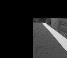

Image(value=b'', format='jpeg', height='300', width='300')

In [7]:
masked_image = detect_lane_markings(image)
image_widget0 = widgets.Image(format='jpeg', width=300, height=300)
display(image_widget0)
image_widget0.value = bgr8_to_jpeg(masked_image)
# display(masked_image.shape)
# display(masked_image[210:225, 0:20])

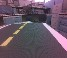

[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [22.]
 [nan]
 [nan]
 [19.]
 [nan]
 [17.]
 [nan]
 [nan]
 [nan]
 [nan]
 [13.]
 [12.]
 [11.]
 [10.]
 [ 9.]
 [ 8.]
 [ 7.]
 [ 7.]
 [ 6.]
 [ 4.]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
k: -29.73
bl: -1.10, br: 1.17, bc: 0.04
c: 36.48, h: 40.5
Left fit error: 31.96
Right fit error: 26.81
u(v) = k/(v-h) + bc*(v-h) + c


In [8]:
visual = Visualization()
ld = Lane_Detection()
tp = Transform_Points()

h, w, _ = image.shape
# print(image.shape)
# h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(np.array(const.mtx), np.array(const.dist), (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(image, np.array(const.mtx), np.array(const.dist), None, newcameramtx)
# display(Image(data=bgr8_to_jpeg(dst)))
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
display(Image(data=bgr8_to_jpeg(dst)))

copy_image = dst.copy()
copy_masked_image = masked_image.copy()
ld.get_initial_lane_points(masked_image)      # Apply Lane initialization on first image
ld.solve_lane()                             # Solve lane model parameters from lane points
ld.lane_sanity_checks(masked_image)           # Apply corrections to lane model
tp.transform_lane_to_poly(ld)               # Calculate polynomial coeff from lane model

visual.draw_lane_lines(copy_image, ld)                             # Draw lane model lines on image
copy_masked_image = cv2.cvtColor(copy_masked_image, cv2.COLOR_GRAY2RGB)   # Generate Edge Image
visual.draw_lane_points(copy_masked_image, ld)                     # Draw lane edge points on image
visual.draw_debug_info(copy_masked_image, ld)
image_widget1 = widgets.Image(format='jpeg', width=300, height=300)
image_widget2 = widgets.Image(format='jpeg', width=300, height=300)
display(widgets.HBox([image_widget1, image_widget2]))
# display(Image(data=bgr8_to_jpeg(copy_image)))                      # Display img with drawing
# display(Image(data=bgr8_to_jpeg(copy_masked_image)))                      # Display img with drawing
image_widget1.value = bgr8_to_jpeg(copy_image)
image_widget2.value = bgr8_to_jpeg(copy_masked_image)

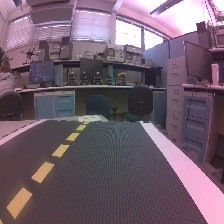

ModuleNotFoundError: No module named 'jetbot'

In [9]:
image = cv2.imread('Test_Lane_Images/image_0.jpg')
display(Image(data=bgr8_to_jpeg(image)))

from jetbot import Camera
import time
camera = Camera.instance
while True:
    clear_output(wait=True)
    image = camera.value
    masked_image = detect_lane_markings(image)
    copy_image2 = image.copy()
    copy_masked_image2 = masked_image.copy()
    for i in range(2):                      # Solve for lane model multiple times for convergence
        ld.lane_points(masked_image)      
        ld.solve_lane()                     # Solve lane model parameters from lane points
        ld.lane_sanity_checks(masked_image)   # Apply corrections to lane model
    tp.transform_lane_to_poly(ld)           # Calculate polynomial coeff from lane model

    visual.draw_lane_lines(copy_image2, ld)                             # Draw lane model lines on image
    copy_masked_image2 = cv2.cvtColor(copy_masked_image2, cv2.COLOR_GRAY2RGB)   # Generate Edge Image
    visual.draw_lane_points(copy_masked_image2, ld)                     # Draw lane edge points on image
    visual.draw_debug_info(copy_masked_image2, ld)
    display(Image(data=bgr8_to_jpeg(copy_image2)))                      # Display img with drawing
    display(Image(data=bgr8_to_jpeg(copy_masked_image2)))                      # Display img with drawing
    time.sleep(0.01)